<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku Reader

In this project a software is developed which recognizes a Sudoku puzzle and solves it automatically.

![Sudoku Puzzle](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/Aufgabe.jpg?raw=1)

## Group members:
* Justine Bruns (Business Informatics)

* Dennis Kempf (Computing Science)

* Mykhailo Ievreinov (Business Informatics)



# Milestones

## Define requirements

In which use cases is a Sudoku solver used?

## Detect Sudoku grid

1. Acquire input image to be analyzed
    1. Read static image from storage
    2. Use real time video stream (optional)

2. Preprocess input image for further analysis

3. Detect shape of Sudoku grid within preprocessed image

![Detect grid](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/detect_grid.png?raw=1)

## Recognize digits

1. Apply perspective transformation to Sudoku grid

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/transform_grid.png?raw=1)

2. Extract cells from grid image

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/extract_cells.png?raw=1)

3. Recognize digits (1 to 9) within cells
    1. Recognize computer generated digits by classical means (e. g. template matching)
    2. Recognize handwritten digits using artificial neural networks (trained on MNIST dataset)
    3. Mark empty cells

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/recognize_digits.png?raw=1)

## Solve puzzle

1. Store recognized digits within matrix data structure 

2. Feed data structure into existing Sudoku solver

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/solve_puzzle.png?raw=1)

3. Output solution to user
    1. Print solved matrix in console
    2. Draw solution onto input image (AR, optional)

![](https://github.com/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/documentation/output_ar.png?raw=1)

# Scenarios

* Sudoku puzzles without entries
* Numbers are difficult to recognize
  * Bad image quality
  * Unclear handwriting
* Image in different rotations
* Multiple Sudokus in one image
  * Maybe a puzzle is not completely visible
* Sudoku in different colors
* Sudoku can have more than one solution
* Sudoku only with handwritten numbers
* Different perspectives on the puzzle
* First numbers were entered into the puzzle, but are incorrect


# Implementation
The following chapters describe the implementation of our Sudoku solver based on the requirements and milestones defined above.

## Acquire Input Images


Our goal is to solve a Sudoku puzzle which is contained within an image (or stream of images).
Thus, first of all, we have to acquire some images to be analyzed.
For the first part of this implementation, we will read a set of static images from our GitHub repository.

The corresponding URLs are defined by the following array.

In [0]:
base_input_image_url = "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/examples"
input_image_urls = [base_input_image_url + "/356/1.jpg",
                    base_input_image_url + "/356/2.jpg",
                    base_input_image_url + "/356/3.jpg",
                    base_input_image_url + "/537/IMG_000.jpeg",
                    base_input_image_url + "/537/IMG_001.jpeg",
                    base_input_image_url + "/537/IMG_002.jpeg"]

We use the **scikit-image** library to download the images specified by the above array.
This library provides a method `io.imread` which reads images not only from local storage, but also from remote origins specified as URLs.
In contrast to OpenCV which encodes color images in BGR format, this method uses the more common RGB encoding.

In [0]:
from skimage import io
from os.path import basename

def download_image(url):
  print("Downloading", url, "...")
  filename = basename(url)
  image = io.imread(url) # encoded in RGB
  return { 
      "url": url,
      "filename": filename,
      "data": image
  }

The downloaded images are stored, together with some meta data, in a `DataFrame` provided by the **Pandas** library.

In [227]:
import pandas as pd

def download_all_images(urls):
  print("Downloading", len(urls), "images...")
  images = [download_image(x) for x in urls]
  return pd.DataFrame(images)

input_images = download_all_images(input_image_urls)
input_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
url         6 non-null object
filename    6 non-null object
data        6 non-null object
dtypes: object(3)
memory usage: 272.0+ bytes


For demonstration purposes the images are then displayed using the **matplotlib** library.

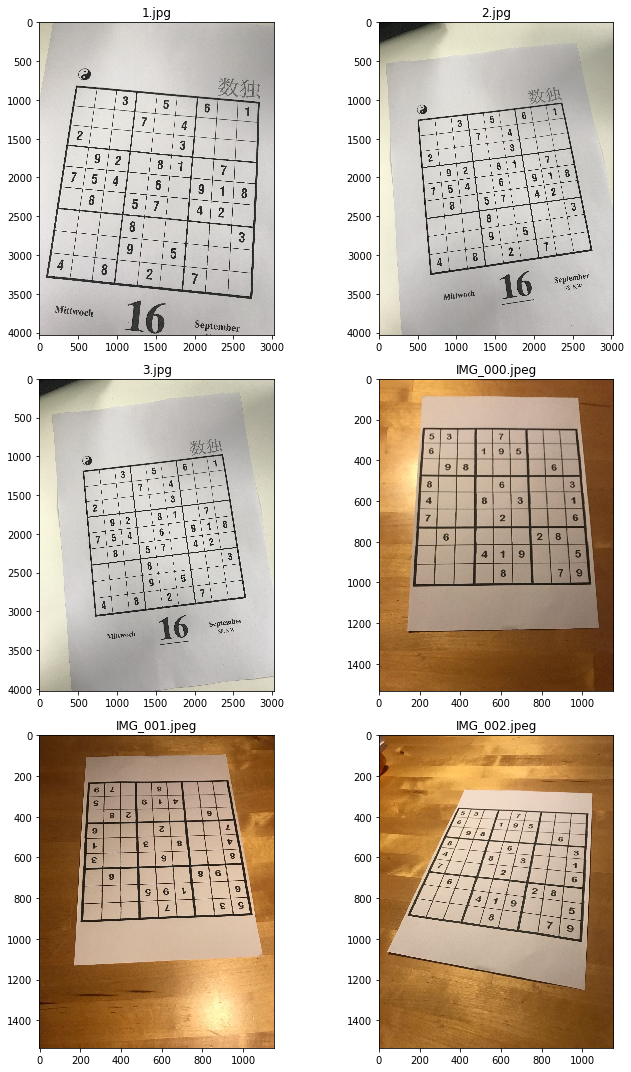

In [228]:
import matplotlib.pyplot as plt
import math

def show_images(images, titles=[], cmap=None, rows=None, columns=None, scaling=(5, 5)):
  if rows == None and columns == None:
    rows = math.ceil(math.sqrt(len(images)))
  if rows == None:
    rows = math.ceil(len(images) / columns)
  if columns == None:
    columns = math.ceil(len(images) / rows)

  plt.figure(figsize=(scaling[1] * columns, scaling[0] * rows))
  for i, image in enumerate(images):
    plt.subplot(rows, columns, i + 1)
    if i < len(titles):
      plt.title(titles[i])
    plt.imshow(image, cmap=cmap)
  plt.tight_layout()
  plt.show()

show_images(input_images["data"], titles=input_images["filename"])

## Preprocess Input Image
Within each of our input images we need to detect the Sudoku grid.
This detection will be done by analyzing the image contours using the **OpenCV2** library.
The `findContours` method requires the image to be binary, i. e. each pixel is completely black or completely white with no inbetween these two colors.
Based on these black and white regions contours/edges will be determined.
But our input images currently contain three color channels, namely **R**ed, **G**reen and **B**lue.
These have to be reduced in an favourable way that keeps the grid contours clearly recognizable.

We start by converting our RGB images to grayscale images using the method `cvtColor` provided by OpenCV.

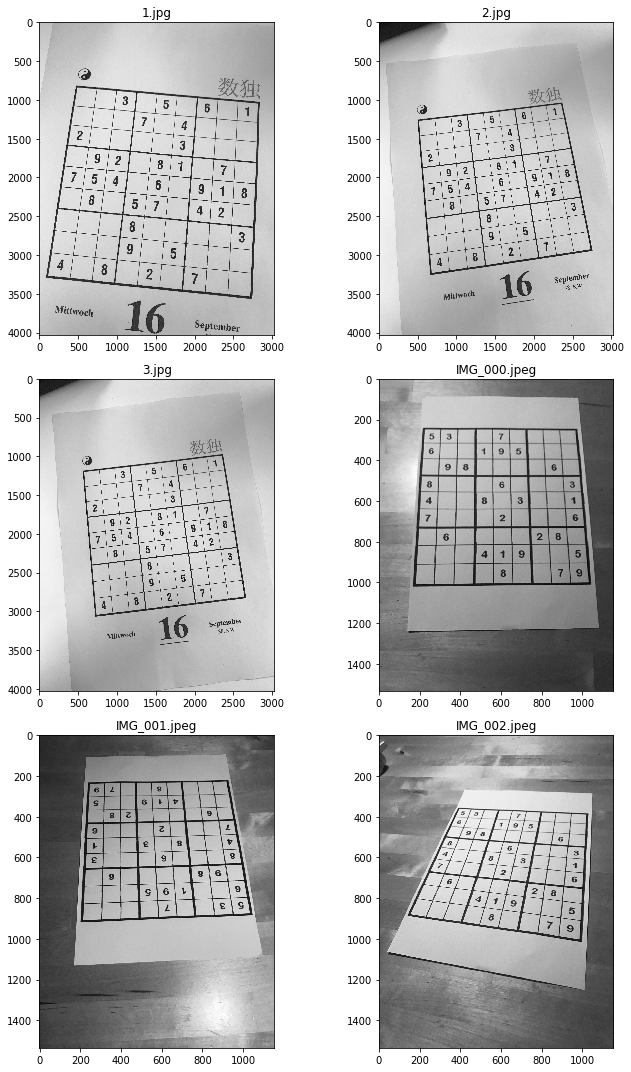

In [229]:
import cv2 as cv

def convert_to_grayscale(image):
  return cv.cvtColor(image, cv.COLOR_RGB2GRAY)

grayscale_input_images = [convert_to_grayscale(x) for x in input_images["data"]]
show_images(grayscale_input_images, titles=input_images["filename"], cmap="gray")

Grayscale images only have one "color" channel, but this one is still not binary.
For this reason we use thresholding, which maps values below some threshold x to "completely black" and values above x to "completely white".
More precisely we use a technique called "adaptive thresholding" which requires us to define a "block size".
The method `adaptiveThreshold` from OpenCV requires the block size to be specified by a number of pixels.
Because we accept different kinds of images with varying resolutions, we define it relative to the image resolution and then convert to an absolute number of pixels as required.


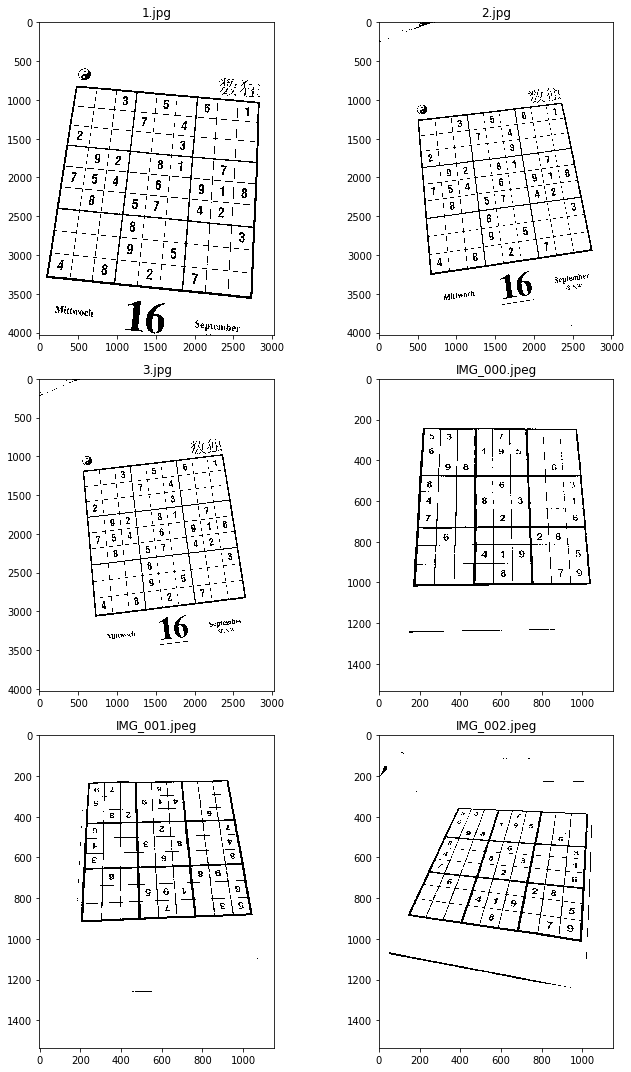

In [230]:
#@title Threshold Configuration { run: "auto" }
default_threshold_block_size = 0.5 #@param { type: "slider", min: 0, max: 1, step: 0.1 }
default_threshold_bias = 64 #@param { type:"slider", min: -255, max: 255, step: 1 }

def threshold_image(image, 
                    method=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                    block_size=default_threshold_block_size, 
                    bias=default_threshold_bias):
  # convert relative block size to absolute block size
  width, height = image.shape
  block_size = int(block_size * min(width, height))
  # if block_size is even, we must make it uneven (see def. of adaptiveThreshold)
  if block_size % 2 == 0:
    block_size += 1
  return cv.adaptiveThreshold(image, 255, method, cv.THRESH_BINARY, block_size, bias)

thresh_input_images = [threshold_image(x) for x in grayscale_input_images]
show_images(thresh_input_images, titles=input_images["filename"], cmap="gray")


## Detect Shape of Sudoku Grid
Finally we can try to detect the shape of a Sudoku grid within each image.
As previously mentioned we do this using the method `findContours` provided by OpenCV.

In [0]:
def find_contours(image):
  # image must be inverted, because findContours treats white as foreground and black as background
  # if we don't invert the image, the image border will be detected as a contour
  image = cv.bitwise_not(image)
  _, contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  return contours

contours = [find_contours(x) for x in thresh_input_images]

The set of found contours can be visualized using the method `drawContours` provided by OpenCV.

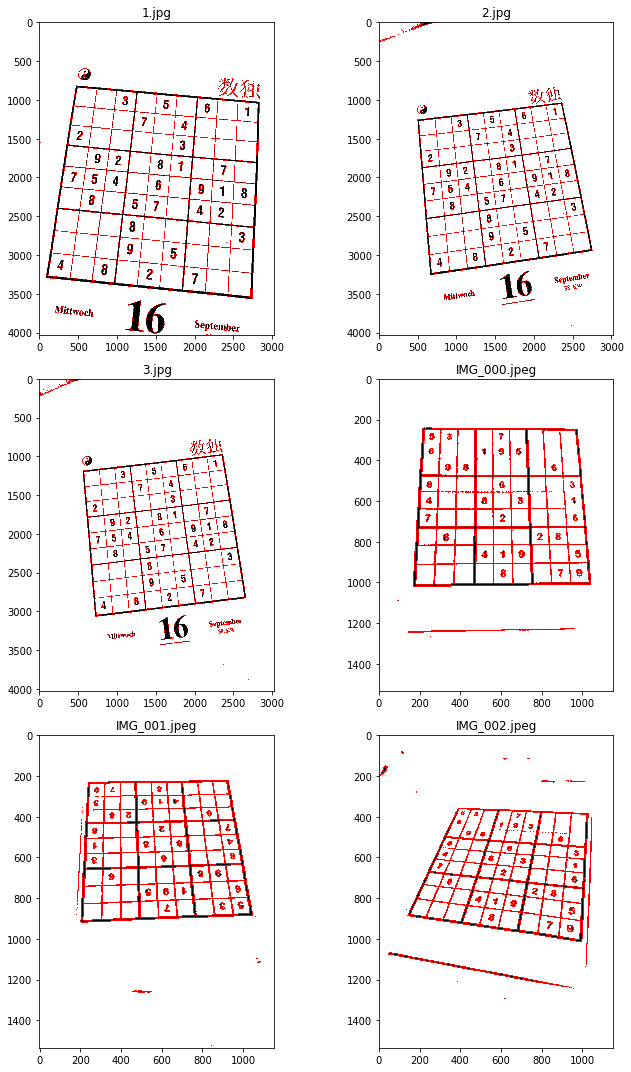

In [232]:
def draw_contours(image, contours):
  # convert image from grayscale to BGR
  image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
  # draw contours using OpenCV
  cv.drawContours(image, contours, -1, color=(0, 0, 255), thickness=4)
  return cv.cvtColor(image, cv.COLOR_BGR2RGB)

images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, contours)]
show_images(images_with_contours, titles=input_images["filename"])

From all of the detected contours we now have to determine which contours are actually corresponding to our Sudoku grid.

**Assumption**: The Sudoku grid always has a square border.

**Idea:** A square has exactly four sides. Thus we can filter out all contours having less than or more than four sides.

The contours generated by `findContours` can be very *wiggly* causing us to overestimate the actual number of sides.
To counter that, we approximate all contours using the method `approxPolyDP` that is also provided by OpenCV.

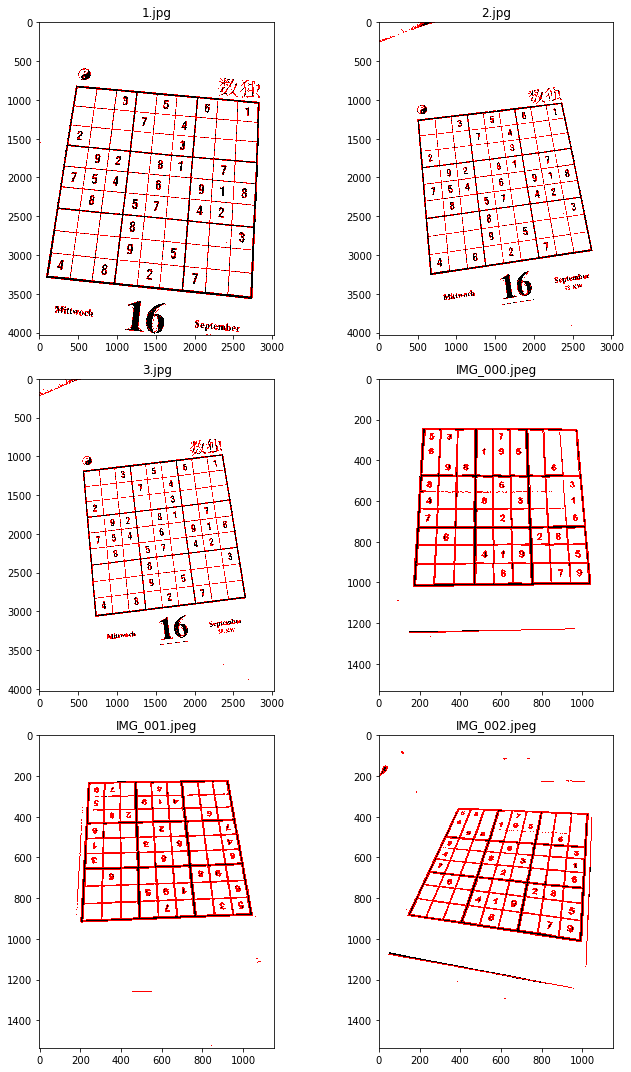

In [233]:
def approximate_contour(contour, precision=0.1):
  # convert relative precision to absolute precision (epsilon)
  _, _, width, height = cv.boundingRect(contour)
  epsilon = max(width, height) * precision
  return cv.approxPolyDP(contour, epsilon, closed=True)

approximated_contours = [[approximate_contour(y) for y in x] for x in contours]
images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, approximated_contours)]
show_images(images_with_contours, titles=input_images["filename"])

Now we can actually filter out all contours that are not foursided.

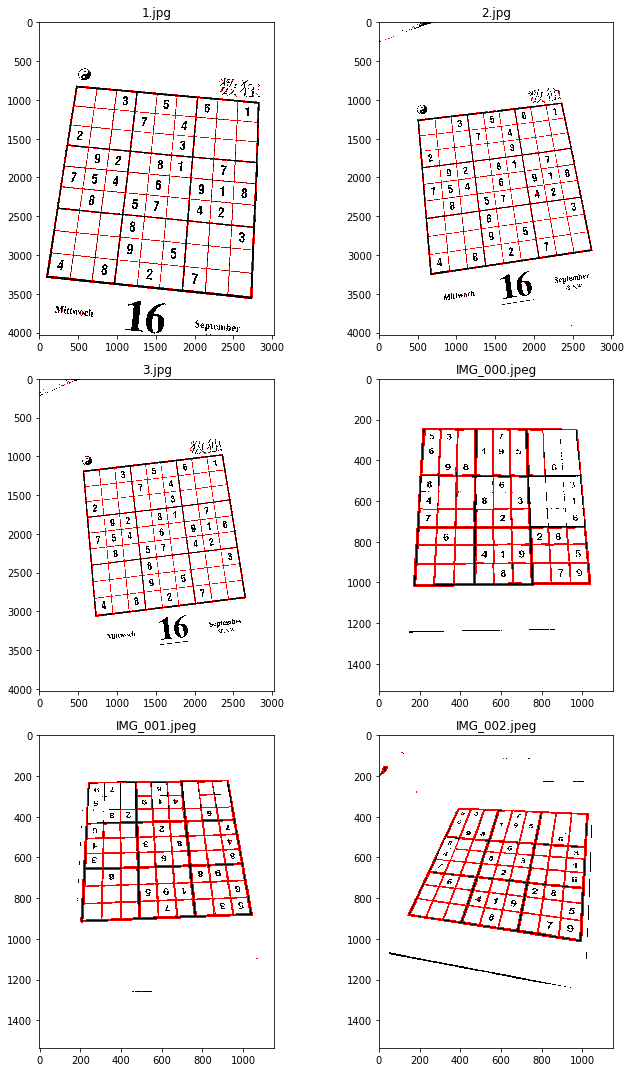

In [234]:
def get_foursided_contours(contours):
  candidates = []
  for contour in contours:
    if len(contour) != 4:
      continue
    candidates.append(contour)
  return candidates

foursided_contours = [get_foursided_contours(x) for x in approximated_contours]
images_with_contours = [draw_contours(x, y) for x, y in zip(thresh_input_images, foursided_contours)]
show_images(images_with_contours, titles=input_images["filename"])

But which of these foursided contours is our Sudoku square?

**Assumption:** The Sudoku grid is always the largest foursided object within all images.

**Idea:** Sort contours by circumference and choose the largest one.

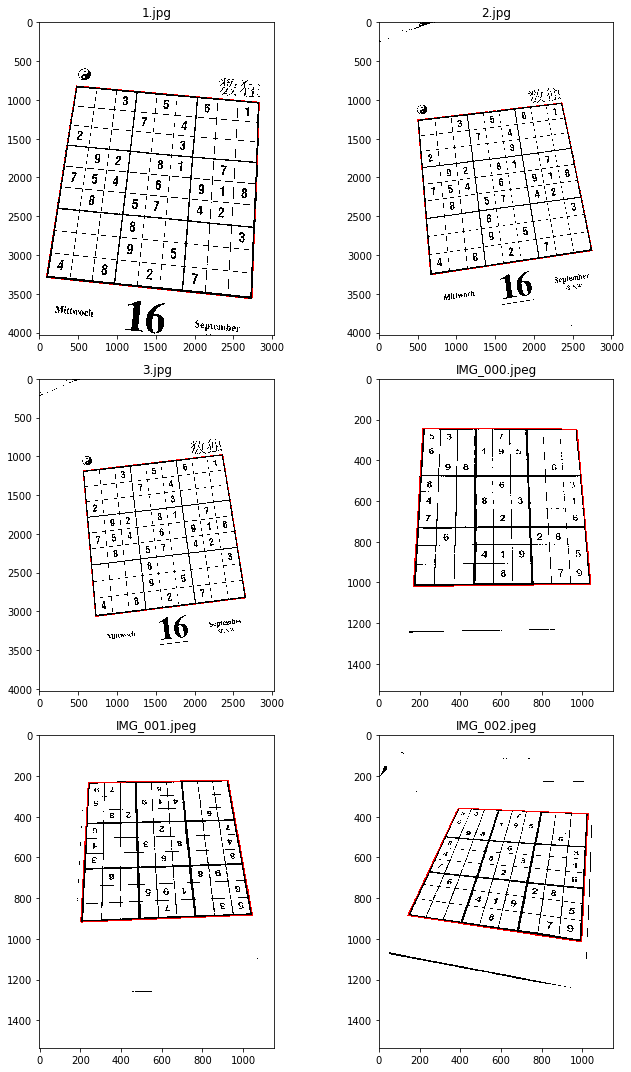

In [235]:
import numpy as np

def get_largest_contour(contours):
  lengths = [cv.arcLength(x, closed=True) for x in contours]
  longest = np.argmax(lengths)
  return contours[longest]

largest_contours = [get_largest_contour(x) for x in foursided_contours]
images_with_contours = [draw_contours(x, [y]) for x, y in zip(thresh_input_images, largest_contours)]
show_images(images_with_contours, titles=input_images["filename"])

## Apply perspective transformation
Because we now know all four corner points of the Sudoku grid, we can apply a transformation to those, removing distortions caused by the camera's perspective.
This transformation is done by first calculating a transformation matrix using OpenCV's `getPerspectiveTransform` and then applying this transformation to our source image using `warpPerspective`.
The method `getPerspectiveTransform` requires us to define a list of source points that are mapped to a list of target points.
For this mapping the order of the points is very important.
If the orders don't match, the resulting image could be rotated by 90°, 180° or 270°.
For this reason, we define a method `sort_corners` that sorts the rectangle's corners in a deterministic way:
- The top-left corner A has the smallest sum of x + y values
- The bottom-left corner B has the largest diff. of y - x values
- The bottom-right corner C has the largest sum of x + y values
- The top-right corner D has the smallest diff. of y - x values

In [0]:
def sort_contour(contour):
  corners = np.reshape(contour, (4, 2))
  indices = np.zeros((4,), dtype="int")
  sums = np.sum(corners, axis=1)
  # [0]: top left corner (smallest sum x + y)
  indices[0] = np.argmin(sums)
  # [2]: bottom right corner (largest sum x + y)
  indices[2] = np.argmax(sums)
  diffs = np.diff(corners, axis=1)
  # [1]: bottom left corner (largest diff. y - x)
  indices[1] = np.argmax(diffs)
  # [3]: top right corner (smallest diff. y - x)
  indices[3] = np.argmin(diffs)
  return corners[indices]
  
sorted_contours = [sort_contour(x) for x in largest_contours]

For the following transformations we have to define the size of our target square.
This could be done in a static way, e. g. scale every image of a Sudoku grid to a 1024x1024 rectangle, or we choose our target dimensions based on the analyzed image.
We decided to use the detected contours circumfrence as a reference for our square side length, which is calculated by the `get_grid_size` method.  

In [0]:
def get_side_length(contour):
  return int(cv.arcLength(contour, closed = True) / 4)

side_lengths = [get_side_length(x) for x in sorted_contours]

As we now know the side lengths of our target squares, we can construct the list of target points the source points are mapped to.
These target points correspond to the four corner points of a square, which are constructed by the method `get_target_contour`.

In [0]:
def get_target_contour(side_length):
  a = [0, 0]
  b = [0, side_length]
  c = [side_length, side_length]
  d = [side_length, 0] 
  return np.array([a, b, c, d]) 

target_contours = [get_target_contour(x) for x in side_lengths] 

From the list of sorted source contours/points and the respective target points we can calculate the necessary linear transformation that warps the source images in the desired way using `get_transformation` which internally invokes OpenCV's `getPerspectiveTransform`. 

In [0]:
def get_transformation(source, destination):
  source = source.astype("float32")
  destination = destination.astype("float32")
  return cv.getPerspectiveTransform(source, destination)

transformations = [get_transformation(x, y) for x, y in zip(sorted_contours, target_contours)]

The resulting transformation matrix can in turn be applied to the source image using `apply_transformation` which invokes OpenCV`s `warpPerspective` method.
Our source images now look like they have been shot straight from above.
Depending on how the Sudoku grid was oriented within the source image, the output image may be rotated. 

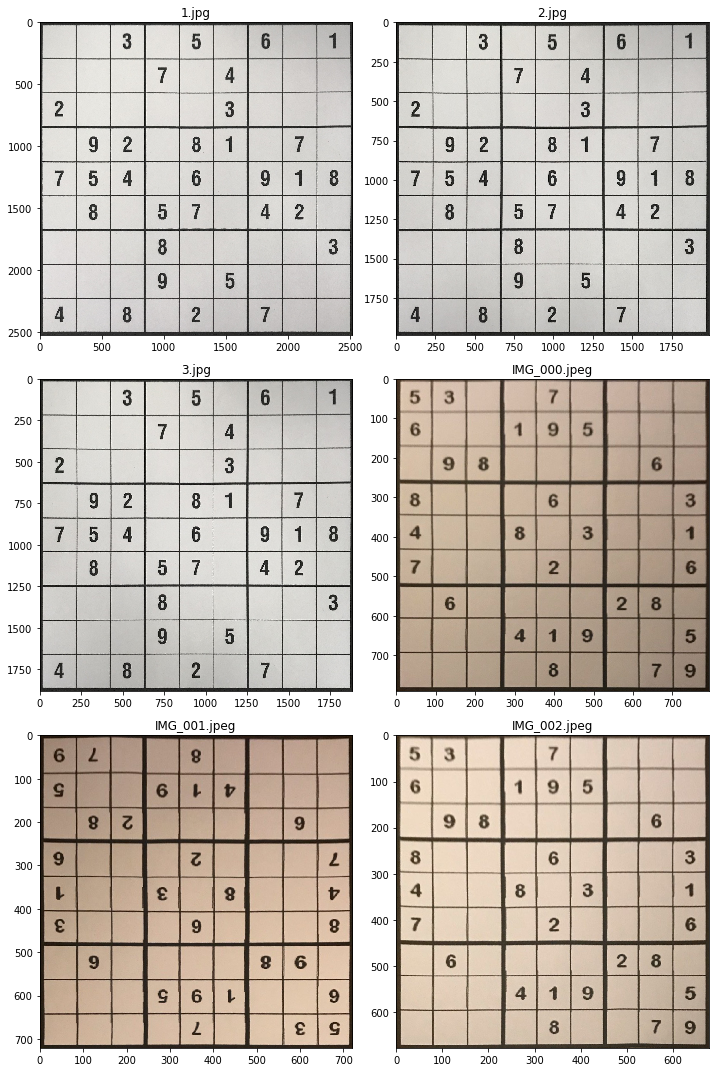

In [240]:
def apply_transformation(image, transformation, side_length):
  return cv.warpPerspective(image, transformation, (side_length, side_length))

transformed_images = [apply_transformation(x, y, z) for x, y, z in zip(input_images["data"], transformations, side_lengths)]
show_images(transformed_images, input_images["filename"])

## Extract cells from grid image

In [0]:
def extract_cells(image):
  split = np.array_split(image, 9)
  for i, x in enumerate(split):
    split[i] = np.array_split(x, 9, axis=1)
  #show_images(split[0])
  return split

cells = [extract_cells(x) for x in transformed_images]

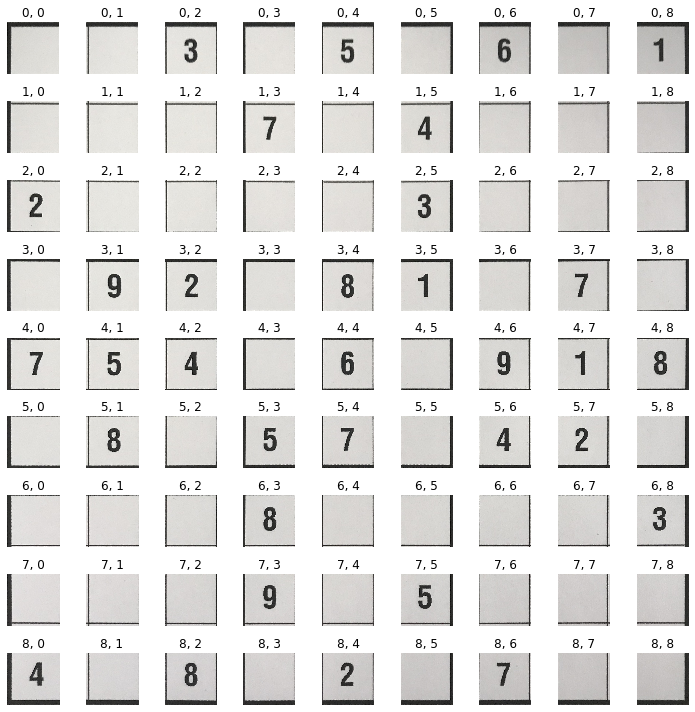

In [256]:
def show_cells(cells):
  plt.figure(figsize=(10, 10))
  rows = len(cells)
  cols = len(cells[0])
  counter = 0
  for row in range(rows):
    for col in range(cols):
      counter += 1
      plt.subplot(rows, cols, counter)
      plt.title("{}, {}".format(row, col))
      plt.axis("off")
      plt.imshow(cells[row][col])
  plt.tight_layout()
  plt.show()

show_cells(cells[0])

In [0]:
resized_cells = [[[cv.resize(cell, (64, 64)) for cell in row] for row in image] for image in cells]

# Recognize digits using template matching

In [0]:
actual_grids = []
for i in range(3):
  actual_grids.append([[0, 0, 3, 0, 5, 0, 6, 0, 1],
                       [0, 0, 0, 7, 0, 4, 0, 0, 0],
                       [2, 0, 0, 0, 0, 3, 0, 0, 0],
                       [0, 9, 2, 0, 8, 1, 0, 7, 0],
                       [7, 5, 4, 0, 6, 0, 9, 1, 8],
                       [0, 8, 0, 5, 7, 0, 4, 2, 0],
                       [0, 0, 0, 8, 0, 0, 0, 0, 3],
                       [0, 0, 0, 9, 0, 5, 0, 0, 0],
                       [4, 0, 8, 0, 2, 0, 7, 0, 0]])
for i in range(3):
  actual_grids.append([[5, 3, 0, 0, 7, 0, 0, 0, 0],
                       [6, 0, 0, 1, 9, 5, 0, 0, 0],
                       [0, 9, 8, 0, 0, 0, 0, 6, 0],
                       [8, 0, 0, 0, 6, 0, 0, 0, 3],
                       [4, 0, 0, 8, 0, 3, 0, 0, 1],
                       [7, 0, 0, 0, 2, 0, 0, 0, 6],
                       [0, 6, 0, 0, 0, 0, 2, 8, 0],
                       [0, 0, 0, 4, 1, 9, 0, 0, 5],
                       [0, 0, 0, 0, 8, 0, 0, 7, 9]])


In [254]:
def print_grid(grid):
  print("-------------------------------------")
  for row in grid:
    for col in row:
      if col >= 1 and col <= 9:
        print("| {} ".format(col), end="")
      else:
        print("|   ", end="")
    print("|\n-------------------------------------")

print_grid(actual_grids[0])

-------------------------------------
|   |   | 3 |   | 5 |   | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------------
|   | 9 | 2 |   | 8 | 1 |   | 7 |   |
-------------------------------------
| 7 | 5 | 4 |   | 6 |   | 9 | 1 | 8 |
-------------------------------------
|   | 8 |   | 5 | 7 |   | 4 | 2 |   |
-------------------------------------
|   |   |   | 8 |   |   |   |   | 3 |
-------------------------------------
|   |   |   | 9 |   | 5 |   |   |   |
-------------------------------------
| 4 |   | 8 |   | 2 |   | 7 |   |   |
-------------------------------------


In [258]:
def get_reference_coords(grid, number):
  grid = np.array(grid)
  where = np.where(grid == number)
  return list(zip(*where))

get_reference_coords(actual_grids[0], 1)

[(0, 8), (3, 5), (4, 7)]

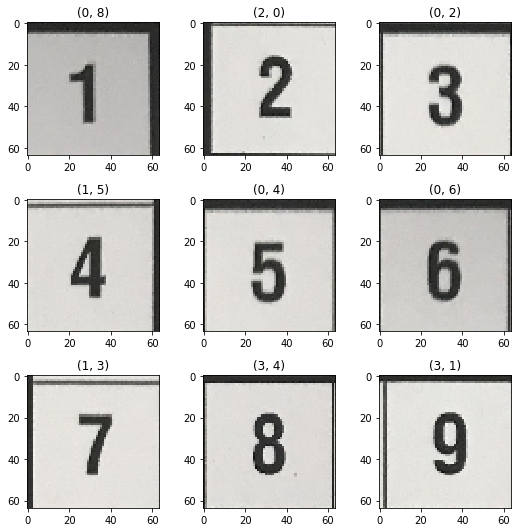

In [259]:
reference_cells = resized_cells[0]
reference_grid = actual_grids[0]
reference_coords = [get_reference_coords(reference_grid, x)[0] for x in range(1, 10)]
reference_cells = [reference_cells[row][col] for row, col in reference_coords]
show_images(reference_cells, titles=reference_coords, scaling=(2.5, 2.5))

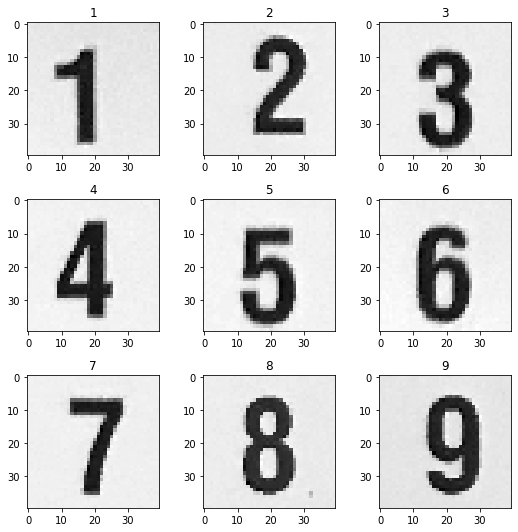

In [260]:
def prepare_template(cell):
  cell = convert_to_grayscale(cell)
  #cell = cv.equalizeHist(cell)
  #_, cell = cv.threshold(cell, 127, 255, cv.THRESH_BINARY)
  return cell

def build_template(cell, padding = 0.2):
  cell = prepare_template(cell)
  p = int(len(cell) * padding)
  cell = cell[p:-p, p:-p]
  return cell

templates = [build_template(x) for x in reference_cells]
show_images(templates, [str(x) for x in range(1, 10)], scaling=(2.5, 2.5), cmap="gray")

In [0]:
def detect_digit(cell, templates, method=cv.TM_SQDIFF_NORMED):
  # prepare cell
  cell = prepare_template(cell)
  # match each template with input cell
  results = []
  for template in templates:
    result = cv.matchTemplate(cell, template, method)
    results.append(result)
  minimums = [np.min(x) for x in results]
  best_result_index = np.argmin(minimums)
  best_result = minimums[best_result_index]
  # compare best result to "empty" template
  mean = int(np.median(cell))
  empty_template = np.ones(cell.shape, dtype="uint8") * mean
  empty_result = cv.matchTemplate(cell, empty_template, method)
  empty_result = np.min(empty_result)
  #print("Empty:", empty_result, "Best:", best_result)
  #empty_result = 1E10
  if empty_result < best_result:
    return 0 # assume no digit
  else:
    return best_result_index + 1 # arrays start at 0 but there is no 0 in a Sudoku

In [269]:
def detect_grid(cells, templates):
  return [[detect_digit(cell, templates) for cell in row] for row in cells]

predicted_grids = [detect_grid(x, templates) for x in resized_cells]

print("Actual:")
print_grid(actual_grids[0])

print("Predicted:")
print_grid(predicted_grids[0])

Actual:
-------------------------------------
|   |   | 3 |   | 5 |   | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------------
|   | 9 | 2 |   | 8 | 1 |   | 7 |   |
-------------------------------------
| 7 | 5 | 4 |   | 6 |   | 9 | 1 | 8 |
-------------------------------------
|   | 8 |   | 5 | 7 |   | 4 | 2 |   |
-------------------------------------
|   |   |   | 8 |   |   |   |   | 3 |
-------------------------------------
|   |   |   | 9 |   | 5 |   |   |   |
-------------------------------------
| 4 |   | 8 |   | 2 |   | 7 |   |   |
-------------------------------------
Predicted:
-------------------------------------
| 7 |   | 3 | 7 | 5 | 7 | 6 |   | 1 |
-------------------------------------
|   |   |   | 7 |   | 4 |   |   |   |
-------------------------------------
| 2 |   |   |   |   | 3 |   |   |   |
-------------------------------

In [270]:
def measure_accuracy(actual_grid, predicted_grid):
  actual_grid = np.array(actual_grid).flatten()
  predicted_grid = np.array(predicted_grid).flatten()
  assert len(actual_grid) == len(predicted_grid)
  n = len(actual_grid)
  correct = incorrect = 0
  for i in range(n):
    if actual_grid[i] == predicted_grid[i]:
      correct += 1
  return correct / n

_n = len(input_images)
_acc_sum = 0
for _i in range(_n):
  _acc = measure_accuracy(actual_grids[_i], predicted_grids[_i])
  _acc_sum += _acc
  print("Grid", _i, "accuracy:", _acc)
print("Average accuracy:", _acc_sum / _n)

Grid 0 accuracy: 0.8024691358024691
Grid 1 accuracy: 0.7283950617283951
Grid 2 accuracy: 0.7283950617283951
Grid 3 accuracy: 0.32098765432098764
Grid 4 accuracy: 0.2222222222222222
Grid 5 accuracy: 0.5185185185185185
Average accuracy: 0.5534979423868314


# Do not look below this line, please!

**Assumption:** The Sudoku grid always has a black border.

**Idea:** Only preserve black (or mostly black) regions within each input image.

But what does it mean for something to be "black"?
In general we can say that something is "black" if it is "dark", i. e. has a low brightness value, and it is "greyish", i. e. has a low saturation value.


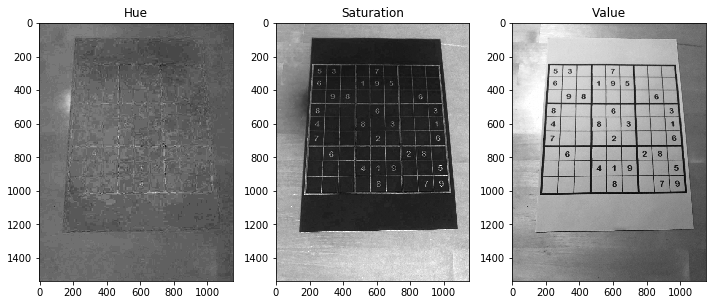

In [252]:
import cv2 as cv
import random

def show_hsv_channels(image):
  image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
  h, s, v = image[:,:,0], image[:,:,1], image[:,:,2]
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 3, 1)
  plt.title("Hue")
  plt.imshow(h, cmap="gray")
  plt.subplot(1, 3, 2)
  plt.title("Saturation")
  plt.imshow(s, cmap="gray")
  plt.subplot(1, 3, 3)
  plt.title("Value")
  plt.imshow(v, cmap="gray")
  plt.tight_layout()
  plt.show()

random_input_image = random.choice(input_images["data"])
show_hsv_channels(random_input_image)